In this notebook I visualize the performance of the various *pre-learning* *BacDive+* models.

## Notebook setup 

In [0]:
# Imports:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
import pandas as pd
import seaborn as sns
import pylab

In [2]:
# Connect to google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
#Set up file paths:
data_folder_location = "gdrive/My Drive/iGEM/Databases/BacDive/Data/"
img_location = "gdrive/My Drive/iGEM/Databases/BacDive/Models/BacDive_Result_Visualization/"
data_filter_location = data_folder_location+"merck_and_co_dup_aa_concat_filter.npy"
X_location = data_folder_location+"X.npy"
y_location = data_folder_location+"y_growth_avg.npy"
default_results_loc = "gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Default/default_cnn_results.csv"
best_results_loc =  "gdrive/My Drive/iGEM/Databases/BacDive/Models/CNN_Regressor_Best_Eval/hypertuned_cnn_results.csv"

print("Folders: ")
print("\t",os.path.isdir(data_folder_location))
print("\t",os.path.isdir(img_location))
print("Files: ")
print("\t",os.path.isfile(data_filter_location))
print("\t",os.path.isfile(X_location))
print("\t",os.path.isfile(y_location))
print("\t",os.path.isfile(default_results_loc))
print("\t",os.path.isfile(best_results_loc))

Folders: 
	 True
	 True
Files: 
	 True
	 True
	 True
	 True
	 True


## Prepare data

In [0]:
y_load = np.load(y_location)
filter_load = np.load(data_filter_location)
y_load = y_load[filter_load]
temp_label_filter = np.logical_not(np.isnan(y_load))
y_label = y_load[temp_label_filter]


In [0]:
default_results = pd.read_csv(default_results_loc)
best_results = pd.read_csv(best_results_loc)

#### Function to easily retrieve cleaned data with split either from drive or cache, depending wheter data was already retrieved using this function ####

In [0]:
def retrieve_data(X_loc, y_loc, test_split=0.2, random_state=42):
  if not(os.path.isfile("X_train_H.npy")):
    #Load data from drive
    print("Loading data from drive...")
    X_load = np.load(X_loc)
    y_load = np.load(y_loc)
    filter_load = np.load(data_filter_location)
    
    #Apply pre filter
    X_load = X_load[filter_load]
    y_load = y_load[filter_load]
    
    #Remove all entries that have no temperature information #can happen, since for some organism specific temperature information is not available
    temp_label_filter = np.logical_not(np.isnan(y_load))
    X_load = X_load[temp_label_filter]
    y_load = y_load[temp_label_filter]
    
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_load, y_load, test_size=test_split, random_state=random_state) 
    
    #Cache data
    print("Caching data...")
    np.save('X_train_H.npy', X_train)   
    np.save('X_test_H.npy', X_test)   
    np.save('y_train_H.npy', y_train)   
    np.save('y_test_H.npy', y_test) 
    
    return X_train, X_test, y_train, y_test
  else:
    print("Loading data from cache...")
    return np.load('X_train_H.npy'), np.load('X_test_H.npy'), np.load('y_train_H.npy'), np.load('y_test_H.npy') 

In [0]:
X_train, X_test, y_train, y_test = retrieve_data(X_location,y_location)
gc.collect()

## Supplementary functions


In [0]:
def plot_hist_label(y_label, x1, y1, title, save_loc):
    sns.set()
    pylab.rc('font', family="Sans", size=16)
    fig, ax = plt.subplots(1, 1, figsize=(7.25,6.5))
    y_label.plot(kind="hist",title=title, color=["lightslategray"], grid=True, fontsize=14, ax=ax, bins=np.arange(0,110,5))
    ax.set_ylabel(y1)
    ax.set_xlabel(x1)
    plt.tight_layout()
    #for label in ax.xaxis.get_ticklabels()[1::2]:
    #  label.set_visible(False)
    plt.savefig(save_loc, dpi=300)
    plt.show()

In [0]:
def plot_results_bar_err(results_df, std_df, title, saveloc, fig_size=(7,6), fig_lim=(2,6)):
  sns.set()
  fig, ax = plt.subplots(figsize=fig_size)
  plt.ylim(fig_lim[0], fig_lim[1])
  results_df.plot.bar(yerr=std_df, ax=ax, color=["lightslategray","lightsteelblue"], title=title, rot=45, width=.7, error_kw=dict(ecolor='dimgrey', lw=1.5, capsize=4, capthick=1.5))
  ax.xaxis.grid(False)
  plt.tight_layout()
  plt.savefig(saveloc, dpi=300)
  plt.show()

## Visualize results

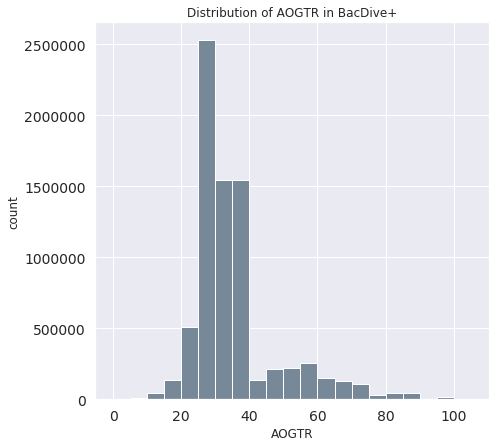

In [0]:
plot_hist_label(pd.Series(y_label),"AOGTR", "count", "Distribution of AOGTR in BacDive+", img_location+"distribution_of_AOGTR_bac_dive.png")

### Collect and calculate results of various models from all sources

In [0]:
default_results.describe()

,MAE_t,RMSE_t,MAE_h,RMSE_h
count,3.000000,3.000000,3.000000,3.000000
mean,6.251873,8.929572,6.240689,8.911697
std,0.067926,0.130447,0.069913,0.127671
min,6.190652,8.794795,6.177663,8.782162
25%,6.215337,8.866754,6.203089,8.848836
50%,6.240022,8.938713,6.228516,8.915510
75%,6.282483,8.996961,6.272202,8.976465
max,6.324944,9.055209,6.315889,9.037419


In [0]:
best_results.describe()

,MAE_t,RMSE_t,MAE_h,RMSE_h,MAE_scale+_h,RMSE_scale+_h
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,5.718116,8.391389,5.709489,8.379040,5.709373,8.379036
std,0.168787,0.110650,0.166912,0.107490,0.166608,0.107630
min,5.568005,8.296353,5.559248,8.286622,5.559368,8.286367
25%,5.626762,8.330651,5.619655,8.320060,5.619714,8.320009
50%,5.685519,8.364948,5.680062,8.353499,5.680059,8.353652
75%,5.793172,8.438906,5.784610,8.425249,5.784376,8.425370
max,5.900824,8.512864,5.889158,8.497000,5.888693,8.497089




```
#baseline (avg prediction) model:
MAE Baseline: 8.912778178475092
RMSE Baseline: 12.695626430809082
```





```
#best whole test train model:
test_mae_whole = 5.454390259456975 #early stopping used on test set, otherwise complete train set used for training
test_rmse_whole =  8.090829165558414
```



### Write results into single table:

In [0]:
model = ["avg_pred","default_t","default_h","best_t","best_h","best_scale+_t","train+"]
value = [[8.912778,12.69562],
         [6.251873,8.929572],
         [6.240689,8.911697],
         [5.718116,8.391389],
         [5.709489,8.379040],
         [5.709373,8.379036],
         [5.454390,8.090829]]
std = [[np.nan,np.nan],
       [0.067926,0.130447],
       [0.069913,0.127671],
       [0.168787,0.110650],
       [0.166912,0.107490],
       [0.166608,0.107630],
       [np.nan,np.nan]]
measure = ["MAE","RMSE"]

values_df = pd.DataFrame(value)
values_df.columns=measure
values_df.index=model

std_df = pd.DataFrame(std)
std_df.columns=measure
std_df.index=model

In [5]:
values_df.head()

,MAE,RMSE
avg_pred,8.912778,12.695620
default_t,6.251873,8.929572
default_h,6.240689,8.911697
best_t,5.718116,8.391389
best_h,5.709489,8.379040


In [6]:
std_df.head()

,MAE,RMSE
avg_pred,NaN,NaN
default_t,0.067926,0.130447
default_h,0.069913,0.127671
best_t,0.168787,0.110650
best_h,0.166912,0.107490


### Plot bar plots and tables and save them

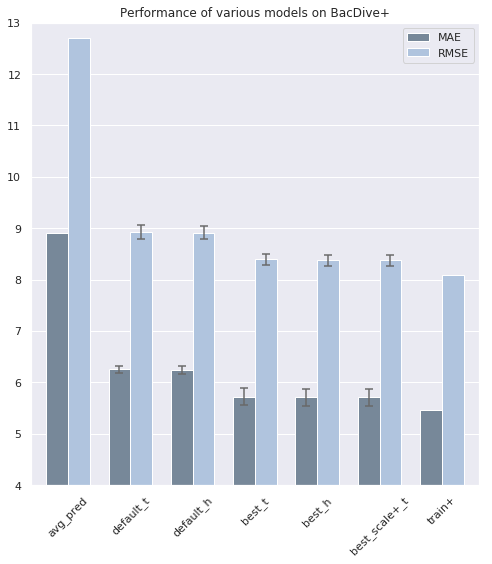

In [10]:
plot_results_bar_err(results_df=values_df,std_df=std_df,title="Performance of various models on BacDive+",saveloc=img_location+"bac_dive_models_performance.png",fig_size=(7,8),fig_lim=(4,13))

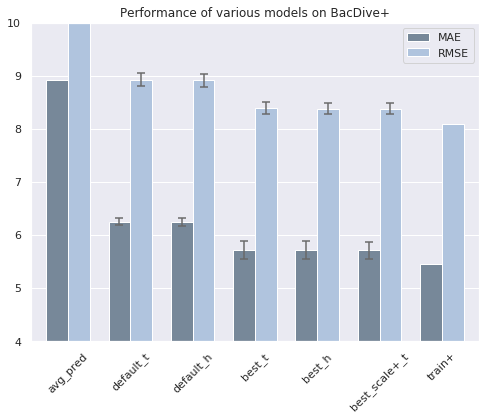

In [11]:
plot_results_bar_err(results_df=values_df,std_df=std_df,title="Performance of various models on BacDive+",saveloc=img_location+"bac_dive_models_performance_cut.png",fig_size=(7,6),fig_lim=(4,10))

In [0]:
std_df.columns = list(map(lambda x: x+"_std",std_df.columns))
results = pd.concat([values_df,std_df], axis=1)

In [13]:
results = results.round(3)
results

,MAE,RMSE,MAE_std,RMSE_std
avg_pred,8.913,12.696,NaN,NaN
default_t,6.252,8.930,0.068,0.130
default_h,6.241,8.912,0.070,0.128
best_t,5.718,8.391,0.169,0.111
best_h,5.709,8.379,0.167,0.107
best_scale+_t,5.709,8.379,0.167,0.108
train+,5.454,8.091,NaN,NaN


In [0]:
results.to_csv(img_location+"bac_dive_results_table_NEW.csv")